In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import connected_components
from time import time

# Map generation

In [2]:
def plot_dungeon(A, B, square_density=3):
    """
    Given two matrices, display the corresponding dungeon.
    
    Parameters
    ----------
    A:  array_like
        Array representing the vertical walls within the 
        dungeon. If A[i, j] is 1, there is a wall at i, j.
        A should be m x n-1.
        
    B:  array_like
        Array representing the horizontal walls within the 
        dungeon. If B[i, j] is 1, there is a wall at i, j.
        B should be m-1 x n.
    
    square_density:  int, optional
        Density of gridlines within the dungeon. Walls
        are typically generated on a more granular grid
        than the gridlines to create more open spaces.
    """
    m, n = A.shape[0], B.shape[1] # dimensions of the grid
    
    def _indices(A):
        """ 
        Helper function to get all the indices of an 
        array without a double for loop.
        """
        m, n = A.shape
        x_indices = np.ravel([[i]*n for i in range(m)])
        y_indices = np.ravel(list(range(n))*m)
        return zip(x_indices, y_indices)

    def _vertical_plot(walls):
        """
        Helper function to plot all vertical walls 
        given an array.
        """
        m, n = walls.shape
        for i, j in _indices(walls):
            if walls[i, j] == 1:
                plt.vlines((j+1)/(n+1), 1-i/(m), 1-(i+1)/(m))

    def _horizontal_plot(walls):
        """
        Helper function to plot all horizontal walls 
        given an array.
        """
        m, n = walls.shape
        for i, j in _indices(walls):
            if walls[i, j] == 1:
                plt.hlines(1-(i+1)/(m+1), j/(n), (j+1)/(n))

    # m and n determine the figsize to help with aspect ratios
    plt.figure(figsize=(20*n/(m+n), 20*m/(m+n)))
    _vertical_plot(A)
    _horizontal_plot(B)

    # plot lines around the edges
    # TODO: make these lines more bold?
    plt.vlines([0, 1], [0, 0], [1, 1])
    plt.hlines([0, 1], [0, 0], [1, 1])
    
    # display only the dungeon
    # TODO: add a small buffer around the edges?
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # add gridlines without displaying ticks
    plt.yticks(np.linspace(0, 1, square_density * m + 1))
    plt.xticks(np.linspace(0, 1, square_density * n + 1))
    plt.grid()
    plt.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)

    
def dungeon_map(m, n, p_wall=0.3, max_connected_components=1):
    """
    Given dimensions m and n, generate a dungeon.
    
    Parameters
    ----------
    m, n:  int
        Integers representing the dimensions of the dungeon.
        
    p_wall:  float, optional
        Float between 0 and 1, specifies the density of
        walls within the dungeon.
    
    max_connected_components: int or None, optional
        Integer representing the maximum number of closed off
        areas within the dungeon. If None, a random dungeon
        will be generated with no constraint on the number of
        closed off spaces.
        
    Returns
    -------
    A:  numpy array
        Array representing the vertical walls within the 
        dungeon. If A[i, j] is 1, there is a wall at i, j.
        A is m x n-1.
        
    B:  numpy array
        Array representing the horizontal walls within the 
        dungeon. If B[i, j] is 1, there is a wall at i, j.
        B is m-1 x n.
        
    C:  numpy array
        Undirected adjacency matrix for the dungeon. C[i, j]
        is 1 if the jth square is adjacent to the ith square.
        Used to determine connected components.
        C is m*n x m*n.
        
    """
    def _adjacency(A, B):
        """
        Helper function to determine the adjacency matrix
        C from wall matrices A and B.
        """
        m, n = A.shape[0], B.shape[1]
        C = np.zeros((m*n, m*n))  # C is m*n x m*n
        
        def _get_i_j(ind):
            """
            Helper function to get the i, j index of a 
            square within the grid given its index in C.
            """
            i = ind // n
            j = ind % n
            return i, j

        def _get_ind(i, j):
            """
            Helper function to get the index in C given
            a square's i, j index within the grid.
            """
            return i*n + j

        # loop over all squares in the grid
        for ind in range(m*n):
            i, j = _get_i_j(ind)

            if i != 0:  # look up
                if B[i-1, j] == 0:  # check for walls
                    C[ind, _get_ind(i-1, j)] = 1
                    
            if i != m-1:  # look down
                if B[i, j] == 0:  # check for walls
                    C[ind, _get_ind(i+1, j)] = 1
                    
            if j != 0:  # look left
                if A[i, j-1] == 0:  # check for walls
                    C[ind, _get_ind(i, j-1)] = 1
                    
            if j != n-1:  # look right
                if A[i, j] == 0:  # check for walls
                    C[ind, _get_ind(i, j+1)] = 1

        return C
    
    # get random wall matrices using p_wall
    A = np.random.choice(2, size=(m, n-1), p=[1-p_wall, p_wall])
    B = np.random.choice(2, size=(m-1, n), p=[1-p_wall, p_wall])
    C = _adjacency(A, B)
    
    # loop until connected components condition is satisfied
    # TODO: add either a maxiter or a timeout
    if max_connected_components is not None:
        while connected_components(C)[0] > max_connected_components:
            A = np.random.choice(2, size=(m, n-1), p=[1-p_wall, p_wall])
            B = np.random.choice(2, size=(m-1, n), p=[1-p_wall, p_wall])
            C = _adjacency(A, B)
    
    return A, B, C

# Encounter Difficulty

In [136]:
# TODO: find monsters with incorrect cr
monster_df.loc['spellcaster-mage-lvl-6']
monster_df.loc['expert-lvl-2']

url                          NaN
cr                             0
type         humanoid (any race)
size                      Medium
ac                            14
hp                            16
speed                        NaN
align              any alignment
legendary                    NaN
source            Essentials Kit
str                          NaN
dex                          NaN
con                          NaN
int                          NaN
wis                          NaN
cha                          NaN
Name: expert-lvl-2, dtype: object

In [3]:
monster_df = pd.read_csv('dnd_monsters.csv', index_col=0)
monster_df.tail()

,url,cr,type,size,ac,hp,speed,align,legendary,source,str,dex,con,int,wis,cha
name,,,,,,,,,,,,,,,,
yuan-ti-pureblood,https://www.aidedd.org/dnd/monstres.php?vo=yua...,1,humanoid (yuan-ti),Medium,11,40,NaN,neutral evil,NaN,Monster Manual (BR),11.0,12.0,11.0,13.0,12.0,14.0
zaratan,NaN,22,elemental,Gargantuan,21,307,swim,neutral,NaN,Mordenkainen's Tome of Foes,NaN,NaN,NaN,NaN,NaN,NaN
zariel,https://www.aidedd.org/dnd/monstres.php?vo=zariel,26,fiend (devil),Large,21,580,fly,lawful evil,Legendary,Mordenkainen's Tome of Foes,27.0,24.0,28.0,26.0,27.0,30.0
zombie,https://www.aidedd.org/dnd/monstres.php?vo=zombie,1/4,undead,Medium,8,22,NaN,neutral evil,NaN,Monster Manual (SRD),13.0,6.0,16.0,3.0,6.0,5.0
zuggtmoy,NaN,23,fiend (demon),Large,18,304,NaN,chaotic evil,NaN,Mordenkainen's Tome of Foes,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
monsters = {'aarakocra': 3, 'yuan-ti-pureblood': 4}
party = {6: 3, 3: 1}

In [5]:
monster_df = pd.read_csv('dnd_monsters.csv', index_col=0)
player_df = pd.read_csv('dnd_player_exp', index_col=0)

cr_to_xp = {
    '0': 10,
    '1/8': 25,
    '1/4': 50,
    '1/2': 100,
    '1': 200,
    '2': 450,
    '3': 700,
    '4': 1100,
    '5': 1800,
    '6': 2300,
    '7': 2900,
    '8': 3900,
    '9': 5000,
    '10': 5900,
    '11': 7200,
    '12': 8400,
    '13': 10000,
    '14': 11500,
    '15': 13000,
    '16': 15000,
    '17': 18000,
    '18': 20000,
    '19': 22000,
    '20': 25000,
    '21': 33000,
    '22': 41000,
    '23': 50000,
    '24': 62000,
    '25': 75000,
    '26': 90000,
    '27': 105000,
    '28': 120000,
    '29': 135000,
    '30': 155000
}

def _quantity_multiplier(n):
    if n <= 1:
        return 1
    elif n <= 2: 
        return 1.5
    elif n <= 6:
        return 2
    elif n <= 10:
        return 2.5
    elif n <= 14:
        return 3
    else:
        return 4

def _monsters_xp(monsters):
    xp = 0
    total_monsters = 0
    for monster in monsters:
        monster_xp = cr_to_xp[monster_df.loc[monster]['cr']]
        xp += monsters[monster] * monster_xp
        total_monsters += monsters[monster]
        
    return _quantity_multiplier(total_monsters) * xp
    
def _party_xp(party, difficulty):
    xp = 0
    for level in party:
        xp += party[level] * player_df.loc[level][difficulty]
        
    return xp

def _encounter_difficulty(party, monsters):
    mxp = _monsters_xp(monsters)
    if mxp < _party_xp(party, 'Easy'):
        return 0
    elif mxp < _party_xp(party, 'Medium'):
        return 1
    elif mxp < _party_xp(party, 'Hard'):
        return 2
    elif mxp < _party_xp(party, 'Deadly'):
        return 3
    else:
        return 4

In [6]:
_encounter_difficulty(party, monsters)

2

# Encounter Generation

In [70]:
difficulty = 'Hard'
difficulty_dict = {
    'Trivial': 0,
    'Easy': 1,
    'Medium': 2,
    'Hard': 3,
    'Deadly': 4,
    0: 'Trivial',
    1: 'Easy',
    2: 'Medium',
    3: 'Hard',
    4: 'Deadly'
}

difficulty = difficulty_dict[difficulty]

def _avg_party_level(party):
    total_levels = np.sum([party[level] * level for level in party])
    party_members = np.sum([party[level] for level in party])
    return total_levels / party_members

def _cr_threshold(row):
    cr = row['cr']
    if pd.isna(cr):
        return False
    if '/' in cr:
        return True
    elif int(cr) <= avg_level:
        return True
    else:
        return False
    
def _max_monsters(monsters, monster):
    while _encounter_difficulty(party, monsters) < difficulty:
        monsters[monster] += 1

    if _encounter_difficulty(party, monsters) > difficulty:
        monsters[monster] -= 1
    
    return monsters[monster]

def _get_available_monsters(monsters, prev_available):
    available_monsters = []
    for monster in prev_available:
        if monster in monsters:
            pass
        cp = monsters.copy()
        cp[monster] = 1
        if _encounter_difficulty(party, cp) <= difficulty:
            available_monsters.append(monster)
    return available_monsters

avg_level = _avg_party_level(party)

monsters = dict()

available_monsters = list(monster_df.index[
    monster_df.apply(_cr_threshold, axis=1)
])

while _encounter_difficulty(party, monsters) < difficulty:
    available_monsters = _get_available_monsters(monsters, available_monsters)

    monster = np.random.choice(available_monsters)
    # TODO: determine if this is necessary:
    # while monster in monsters:
    #     monster = np.random.choice(available_monsters)
    monsters[monster] = 1

    max_monster_quantity = _max_monsters(monsters, monster)
    monsters[monster] = np.random.randint(1, max_monster_quantity + 1)

print(monsters)
print(difficulty_dict[_encounter_difficulty(party, monsters)])

{'dolphin': 17, 'eagle': 3, 'giant-centipede': 5, 'baboon': 1, 'pony': 1}
Hard


In [8]:
test_encounter = {'xvart-warlock-of-raxivort': 1, 'spellcaster-mage-lvl-6': 11, 'tortle': 4, 'choker': 1, 'jackalwere': 1}

In [129]:
_encounter_difficulty(party, test_encounter)

3

In [164]:
player_np = np.array([
    [25, 50, 75, 100],
    [50, 100, 150, 200],
    [75, 150, 225, 400],
    [125, 250, 375, 500],
    [250, 500, 750, 1100],
    [300, 600, 900, 1400],
    [350, 750, 1100, 1700],
    [450, 900, 1400, 2100],
    [550, 1100, 1600, 2400],
    [600, 1200, 1900, 2800],
    [800, 1600, 2400, 3600],
    [1000, 2000, 3000, 4500],
    [1100, 2200, 3400, 5100],
    [1250, 2500, 3800, 5700],
    [1400, 2800, 4300, 6400],
    [1600, 3200, 4800, 7200],
    [2000, 3900, 5900, 8800],
    [2100, 4200, 6300, 9500],
    [2400, 4900, 7300, 10900],
    [2800, 5700, 8500, 12700]
])

In [170]:
player_df = pd.DataFrame(data=player_np, columns=['Easy', 'Medium', 'Hard', 'Deadly'])
player_df['Player Level'] = range(1, 21)
player_df.set_index('Player Level', inplace=True)
player_df.head()

,Easy,Medium,Hard,Deadly
Player Level,,,,
1,25,50,75,100
2,50,100,150,200
3,75,150,225,400
4,125,250,375,500
5,250,500,750,1100


In [173]:
player_df = pd.read_csv('dnd_player_exp', index_col=0)
player_df.head()

,Easy,Medium,Hard,Deadly
Player Level,,,,
1,25,50,75,100
2,50,100,150,200
3,75,150,225,400
4,125,250,375,500
5,250,500,750,1100


In [109]:
a = {1:2, 2:3}
b = a.copy()
b[1] = 3
print(a, b)

{1: 2, 2: 3} {1: 3, 2: 3}


# Encounter placement

In [24]:
def place_encounters(m, n, square_density=3):
    D = np.zeros((square_density*m, square_density*n))

    # TODO: implement Dijkstra's algorithm
    treasure_location = [(1, 1), (square_density*m-2, 1), (square_density*m-2, square_density*n-2)][np.random.choice(3)]
    party_location = (1, square_density*n-2)

    D[treasure_location[0], treasure_location[1]] = 4
    D[party_location[0], party_location[1]] = -1

    def _indices(A):
        """ 
        Helper function to get all the indices of an 
        array without a double for loop.
        """
        m, n = A.shape
        x_indices = np.ravel([[i]*n for i in range(m)])
        y_indices = np.ravel(list(range(n))*m)
        return list(zip(x_indices, y_indices))

    inds = _indices(D)

    locations = [treasure_location, party_location]

    for i in [1, 2, 3]:
        valid_location = False
        while not valid_location:
            new_location = inds[np.random.choice(len(inds))]
            valid_location = True
            for existing_location in locations:
                if np.linalg.norm(np.array(new_location) - np.array(existing_location)) < 12:
                    valid_location = False
                    pass

        locations.append(new_location)
        D[new_location[0], new_location[1]] = i
        
    return D

def plot_encounters(D, square_density=3):
    m, n = D.shape[0]/square_density, D.shape[1]/square_density
    def _indices(A):
        """ 
        Helper function to get all the indices of an 
        array without a double for loop.
        """
        m, n = A.shape
        x_indices = np.ravel([[i]*n for i in range(m)])
        y_indices = np.ravel(list(range(n))*m)
        return list(zip(x_indices, y_indices))
    
    color_dict = {
        -1: 'cornflowerblue',
        1: 'darkseagreen',
        2: 'gold',
        3: 'darkorange',
        4: 'indianred'
    }

    for i, j in _indices(D):
        if D[i, j] > 0:
            plt.scatter((i+.5)/(square_density*m), 1 - (j+.5)/(square_density*n), marker='X', s=500*D[i, j], c=color_dict[D[i, j]])
        elif D[i, j] == -1:
            plt.scatter((i+.5)/(square_density*m), 1 - (j+.5)/(square_density*n), marker='v', s=500, c=color_dict[D[i, j]])


# Generate Dungeon

In [25]:
def generate_dungeon(m=10, n=10, square_density=3):
    # start = time()
    A, B, C = dungeon_map(m, n, p_wall=0.3, max_connected_components=1)
    # print(time() - start)
    
    D = place_encounters(m, n, square_density=square_density)
    
    plot_dungeon(A, B, square_density=square_density)
    plot_encounters(D, square_density=square_density)
    plt.show()

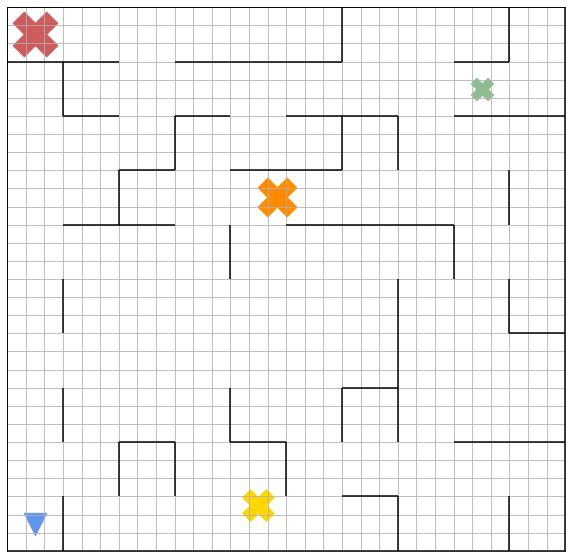

In [62]:
generate_dungeon()